# Forces

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
sys.path.insert(0, '../../../icenumerics/')
sys.path.insert(0, './../auxnumerics/')
sys.path.insert(0, '../')
import icenumerics as ice


from parameters import params
import auxiliary as aux
import montecarlo_colloids as mc
import vertices as vrt

ureg = ice.ureg

%reload_ext autoreload
%autoreload 2

idx = pd.IndexSlice

In [2]:
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'xtick.labelsize':11,
    'ytick.labelsize':11,
    'axes.labelsize':11,
})

# Counts of flips up to some point
Here I counted how my flips have happened up to some time.

In [3]:
DRIVE = '/home/frieren/BIG/'
DRIVE = '/mnt/BIG/'
PROJECT = 'reentrancy/test11'
SIZE = 10
DATA_PATH = os.path.join(DRIVE,PROJECT,str(SIZE))

This cell computes how many particles are on the other side of the trap.

In [13]:
ifile = 'dishorrp_20mT.csv'
#ifile = 'disverrp_20mT.csv'

ofile = 'countshorrp_20mT.csv'
#ofile = 'countsverrp_20mT.csv'

hors = pd.read_csv(os.path.join(DATA_PATH,ifile),header=0)
particle_cols = hors.columns[:-5].to_list()

# here we go by omega values
makeheaders = True
for ttime, dft in hors.groupby('total_time'):
    
    # here we normalize with respect to the trap separation
    normalized = dft[particle_cols] / params['trap_sep'].magnitude
    # and sum the particles that crossed the stuff with time
    # we consider crossed as 0.9 of the trap sep
    counts = pd.DataFrame((normalized>=0.5).sum(axis=1),columns=['counts'])
    counts['total_time'] = [ttime] * len(counts)
    counts['t'] = dft.t
    
    if makeheaders:
        counts.to_csv(os.path.join(DATA_PATH,ofile),mode='w',index=False)
        makeheaders=False
    else:
        counts.to_csv(os.path.join(DATA_PATH,ofile),mode='a',index=False, header=None)

This cell averages distances with time.

In [4]:
ifile = 'disverrp_20mT.csv'
ofile = 'veravrp.csv'

hors = pd.read_csv(os.path.join(DATA_PATH,ifile),header=0)
particle_cols = hors.columns[:-5].to_list()
rest_cols = [x for x in hors.columns if x not in particle_cols]

df = hors[particle_cols].mean(axis=1).to_frame()
df[rest_cols] = hors[rest_cols]
df.columns = ['mean'] + rest_cols


df.to_csv(os.path.join(DATA_PATH,ofile),mode='w',index=False)

# Time for the real stuff

In [4]:
# open the averaged distances across particles
# average across realizations
dish = pd.read_csv(os.path.join(DATA_PATH,'horavrp.csv')
                  ).groupby(['total_time','t'])['mean'].mean().to_frame().reset_index()

disv = pd.read_csv(os.path.join(DATA_PATH,'veravrp.csv')
                  ).groupby(['total_time','t'])['mean'].mean().to_frame().reset_index()

# and put the omega values
dish['omega'] = np.round(np.pi/2/dish['total_time'],4)
disv['omega'] = np.round(np.pi/2/dish['total_time'],4)

In [5]:
countsh = pd.read_csv(os.path.join(DATA_PATH,'countshorrp_20mT.csv'),index_col=['total_time','t'])

countsv = pd.read_csv(os.path.join(DATA_PATH,'countsverrp_20mT.csv'),index_col=['total_time','t'])
n_particles = 2 * params['size']**2

fractions = pd.DataFrame( pd.concat([countsh,countsv],axis=1).sum(axis=1) / n_particles , columns=['fractions']) 
fractions['omega'] = np.round(np.pi/2/fractions.index.get_level_values('total_time').to_numpy(),4)

ws = fractions.omega.unique()
ws = ws[(ws<=0.2) & (ws>=0.01)]
ws

array([0.1963, 0.1745, 0.1571, 0.1428, 0.1309, 0.1208, 0.1122, 0.1047,
       0.0982, 0.0924, 0.0873, 0.0827, 0.0785, 0.0524, 0.0393, 0.0314,
       0.0224, 0.0196, 0.0175, 0.0157])

In [6]:
averaged = fractions.reset_index().groupby(['total_time','t'])['fractions'].mean().to_frame().reset_index()
averaged['omega'] = np.round(np.pi/2/averaged['total_time'].to_numpy(),4)

#  Version 1

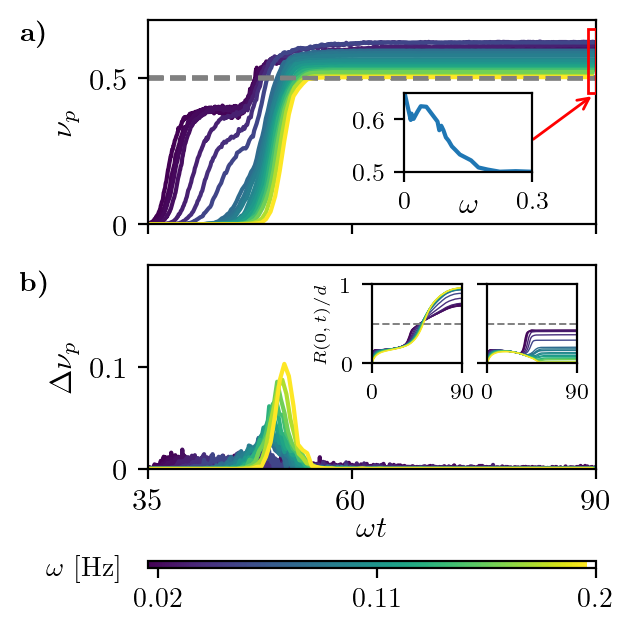

In [7]:
fig, axes = plt.subplots(2,1, figsize=(3.2,3.3), dpi=200)
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches
from matplotlib.ticker import MultipleLocator


norm = plt.Normalize(min(ws),max(ws))
cmap = plt.get_cmap('viridis')

ylabels = ['$\\nu_p$','$\\Delta \\nu_p$']

# ==========================================================================================================
# MAIN PLOTS
# ==========================================================================================================

rect = patches.Rectangle((89, 0.45), 1, 0.22, linewidth=1, edgecolor='red', facecolor='none', linestyle='-',zorder=20)
axes[0].add_patch(rect)

for w, dfw in averaged.groupby('omega'):
    if w in ws:
        theta = (dfw.omega * dfw.t) * 180/np.pi
        axes[0].plot(theta, dfw.fractions, color=cmap(norm(w)))
        axes[0].axhline(y=0.5,linestyle='--', color='gray')
        axes[1].plot(theta[1:],(np.diff(dfw.fractions)) , color=cmap(norm(w)))

# some stuff for main plots
for i in range(2):
    
    
    axes[i].set_xlim(35,90)
    axes[i].set_ylabel(ylabels[i])
    axes[i].set_xticks([35,60,90])
    axes[i].set_xticklabels([35,60,90])
    
    if i==0:
        axes[i].set_ylim(0,0.7)
        axes[i].set_xticklabels([])
        
        axes[i].set_yticks([0,0.5])
        axes[i].set_yticklabels([0,0.5])
    else:
        axes[i].set_ylim(0,0.2)
        axes[i].set_yticks([0,0.1])
        axes[i].set_yticklabels([0,0.1])
        axes[i].set_xlabel('$\\omega t$',labelpad=0) 


# ==========================================================================================================
# INSETS
# ==========================================================================================================
 
# ===== last frame of particle counts vs omega ===== #
max_times = {w:df['t'].max() for w,df in averaged.groupby('omega')}
counts_last = pd.concat( averaged.query(f'omega=={w} & t=={t}') for w,t in max_times.items() if w<=0.5)

axins = fig.add_axes([0.6, 0.65, 0.2, 0.12])  # Adjust these values as needed
axins.plot(counts_last.omega, counts_last.fractions)
axins.set_xlabel('$\\omega$',labelpad=-8)
axins.set_ylim(0.5, 0.65)
axins.set_xlim(0, 0.3)

axins.set_xticks([0,0.3])
axins.set_xticklabels([0,0.3])
axins.tick_params(axis='both', labelsize=9)

axes[0].annotate('', xy=(90, 0.45), xycoords='data',
            xytext=(0.85, 0.4), textcoords='axes fraction',
            arrowprops=dict(arrowstyle='->', linestyle='solid', color='red'))


# ===== horizontal travelled distance ===== #
axins = fig.add_axes([0.55, 0.36, 0.14, 0.12])  # Adjust these values as needed
for w, dfw in dish.groupby('omega'):
    if w in ws:
        axins.plot(dfw.t*w*180/np.pi, dfw['mean']/params['trap_sep'].magnitude, 
                   color=cmap(norm(w)),
                   linewidth=0.5)
axins.axhline(0.5,color='gray',linestyle='--', linewidth=0.7)
axins.set_ylabel('$R(0,t)/d$',fontsize=6)
axins.set_xlim(0,90)
axins.set_ylim(0,1)
axins.set_xticks([0,90])
axins.set_xticklabels([0,90])
axins.set_yticks([0,1])
axins.set_yticklabels([0,1])
axins.tick_params(axis='both', labelsize=8)


# ===== vertical travelled distance ===== #
axins = fig.add_axes([0.73, 0.36, 0.14, 0.12])
for w, dfw in disv.groupby('omega'):
    if w in ws:
        axins.plot(dfw.t*w*180/np.pi, dfw['mean']/params['trap_sep'].magnitude, 
                   color=cmap(norm(w)),
                   linewidth=0.5)
        
axins.axhline(0.5,color='gray',linestyle='--', linewidth=0.7)
axins.set_xlim(0,90)
axins.set_ylim(0,1)
axins.set_xticks([0,90])
axins.set_xticklabels([0,90])
axins.set_yticklabels([])
axins.tick_params(axis='both', labelsize=8)


# ==========================================================================================================
# COLORBAR
# ==========================================================================================================
 
fig.subplots_adjust(bottom=0.2)  # Adjust the bottom space to make room for the colorbar
fig.subplots_adjust(left=0.2)  # Adjust the bottom space to make room for the shared axis label

cbar_ax = fig.add_axes([0.2, 0.05, 0.7, 0.01])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Set an empty array to the ScalarMappable

cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
#cbar.set_label(label='$\\omega$ [Hz]', fontsize=10)
cbar.ax.tick_params(labelsize=10)

custom_ticks = np.round(np.array([min(ws), (min(ws)+max(ws)/2) ,max(ws)]),2)
cbar.set_ticks(custom_ticks)
cbar.set_ticklabels(custom_ticks)

fig.text(0.1, 0.05, '$\\omega$ [Hz]', fontsize=10, ha='center', va='center')

# ==========================================================================================================
# SUBFIGURE TEXTS
# ==========================================================================================================

#fig.subplots_adjust(left=0.2)  # Adjust the bottom space to make room for the shared axis label

fig.text(0,0.85,'\\textbf{a)}')
fig.text(0,0.47,'\\textbf{b)}')

plt.show()
fig.savefig('/home/frieren/Dropbox/mnt/martensitepaper/fig4.pdf',dpi=300,bbox_inches='tight')
fig.savefig('/home/frieren/Dropbox/mnt/martensitepaper/fig4.png',dpi=300,bbox_inches='tight')

# Version 2

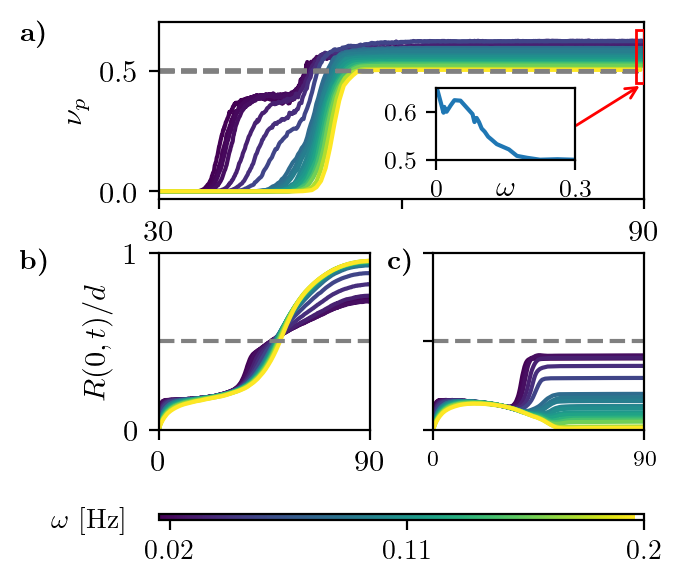

In [17]:
import matplotlib.gridspec as gridspec

COL = 246/72
OFFSET = 0.052

fig = plt.figure(figsize=(COL+OFFSET, 3),dpi=200)
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], hspace=0.3, wspace=0.3)
fig.tight_layout()

# ==========================================================================================================
# TOP PLOT
# ==========================================================================================================

ax = fig.add_subplot(gs[0,:])
rect = patches.Rectangle((89, 0.45), 1, 0.22, linewidth=1, edgecolor='red', facecolor='none', linestyle='-',zorder=20)
ax.add_patch(rect)

for w, dfw in averaged.groupby('omega'):
    if w in ws:
        theta = (dfw.omega * dfw.t) * 180/np.pi
        ax.plot(theta, dfw.fractions, color=cmap(norm(w)))
        ax.axhline(y=0.5,linestyle='--', color='gray')
ax.set_xlim(30,90)
ax.set_xticks([30,60,90])
ax.set_xticklabels([30,'',90])
ax.set_ylabel('$\\nu_p$')
#ax.minorticks_on()

# ===== inset ===== #
max_times = {w:df['t'].max() for w,df in averaged.groupby('omega')}
counts_last = pd.concat( averaged.query(f'omega=={w} & t=={t}') for w,t in max_times.items() if w<=0.5)

axins = fig.add_axes([0.6, 0.65, 0.2, 0.12])  # Adjust these values as needed
axins.plot(counts_last.omega, counts_last.fractions)
axins.set_xlabel('$\\omega$',labelpad=-10)
axins.set_ylim(0.5, 0.65)
axins.set_xlim(0, 0.3)

axins.set_xticks([0,0.3])
axins.set_xticklabels([0,0.3])
axins.tick_params(axis='both', labelsize=9)

ax.annotate('', xy=(90, 0.45), xycoords='data',
            xytext=(0.85, 0.4), textcoords='axes fraction',
            arrowprops=dict(arrowstyle='->', linestyle='solid', color='red'))

# ==========================================================================================================
# BOTTOM PLOTS
# ==========================================================================================================

# ===== horizontal traps ===== #
ax = fig.add_subplot(gs[1,0])
for w, dfw in dish.groupby('omega'):
    if w in ws:
        ax.plot(dfw.t*w*180/np.pi, dfw['mean']/params['trap_sep'].magnitude, color=cmap(norm(w)))
ax.axhline(0.5,color='gray',linestyle='--')
ax.set_ylabel('$R(0,t)/d$',fontsize=11)
ax.set_xlim(0,90)
ax.set_ylim(0,1)
ax.set_xticks([0,90])
ax.set_xticklabels([0,90])
ax.set_yticks([0,1])
ax.set_yticklabels([0,1])


# ===== vertical travelled distance ===== #
ax = fig.add_subplot(gs[1,1])
for w, dfw in disv.groupby('omega'):
    if w in ws:
        ax.plot(dfw.t*w*180/np.pi, dfw['mean']/params['trap_sep'].magnitude, color=cmap(norm(w)))
        
ax.axhline(0.5,color='gray',linestyle='--')
ax.set_xlim(0,90)
ax.set_ylim(0,1)
ax.set_xticks([0,90])
ax.set_xticklabels([0,90])
ax.set_yticklabels([])
ax.tick_params(axis='both', labelsize=8)

# ==========================================================================================================
# COLORBAR
# ==========================================================================================================
 
fig.subplots_adjust(bottom=0.2)  # Adjust the bottom space to make room for the colorbar
fig.subplots_adjust(left=0.2)  # Adjust the bottom space to make room for the shared axis label

cbar_ax = fig.add_axes([0.2, 0.05, 0.7, 0.01])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Set an empty array to the ScalarMappable

cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
#cbar.set_label(label='$\\omega$ [Hz]', fontsize=10)
cbar.ax.tick_params(labelsize=10)

custom_ticks = np.round(np.array([min(ws), (min(ws)+max(ws)/2) ,max(ws)]),2)
cbar.set_ticks(custom_ticks)
cbar.set_ticklabels(custom_ticks)

fig.text(0.1, 0.05, '$\\omega$ [Hz]', fontsize=10, ha='center', va='center')

# ==========================================================================================================
# SUBFIGURE TEXTS
# ==========================================================================================================

#fig.subplots_adjust(left=0.2)  # Adjust the bottom space to make room for the shared axis label

fig.text(0,0.85,'\\textbf{a)}')
fig.text(0,0.47,'\\textbf{b)}')
fig.text(0.53,0.47,'\\textbf{c)}')

plt.show()
fig.savefig('/home/frieren/Dropbox/mnt/martensitepaper/fig4.pdf',dpi=300,bbox_inches='tight')
fig.savefig('/home/frieren/Dropbox/mnt/martensitepaper/fig4.png',dpi=300,bbox_inches='tight')

plt.show()

##  Widths
Here I define the width as the complete range of changes in the simulation. That is, the first angle where particles move and the last where they move.
We define this range as
$$
\nu_p \geq \dfrac{1}{n_p n_r}
$$
where $n_p$ is the number of particles and $n_r$ the number of realizations.

In [9]:
omegas = [w for w, dfw in averaged.groupby('omega')]
dth = []
for w, dfw in averaged.groupby('omega'):
    whole_range = dfw.sort_values('t').query(f'fractions>={1/2/params['size']/10}')
    theta = (whole_range.omega  * whole_range.t).to_numpy() * 180/np.pi
    dth.append(theta[-1] - theta[0])

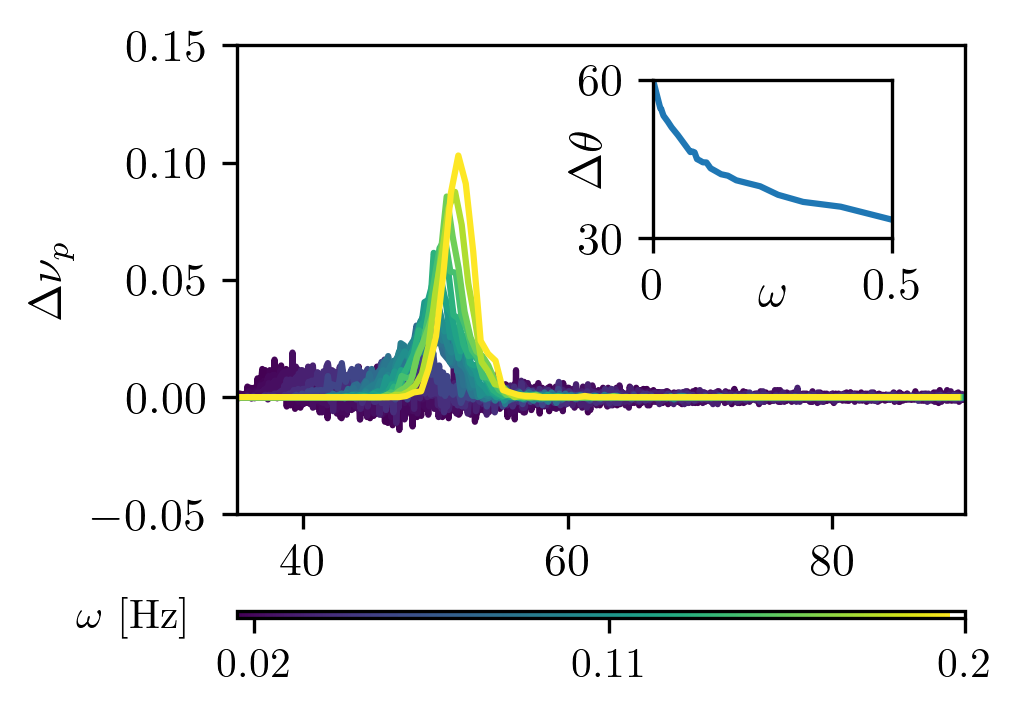

In [18]:
COL = 246/72
OFFSET = 0.05
fig, ax = plt.subplots(figsize=(COL+OFFSET,2.3),dpi=300)

# ==========================================================================================================
# MAIN PLOT
# ==========================================================================================================
 
for w, dfw in averaged.groupby('omega'):
    if w in ws:
        theta = (dfw.omega * dfw.t) * 180/np.pi
        ax.plot(theta[1:],(np.diff(dfw.fractions)) , color=cmap(norm(w)))
ax.set_xlim(35,90)
ax.set_ylim(-0.05,0.15)
ax.set_ylabel('$\\Delta \\nu_p$')

# ==========================================================================================================
# INSET
# ==========================================================================================================
 
axins = fig.add_axes([0.6, 0.6, 0.23, 0.23])
axins.plot(omegas,dth)
axins.set_xlabel('$\\omega$',labelpad=-8)
axins.set_ylabel('$\\Delta \\theta$',labelpad=-8)
axins.set_xlim(0,0.5)
axins.set_ylim(30,60)

axins.set_xticks([0,0.5])
axins.set_xticklabels([0,0.5])

axins.set_yticks([30,60])
axins.set_yticklabels([30,60])

# ==========================================================================================================
# COLORBAR
# ==========================================================================================================
 
fig.subplots_adjust(bottom=0.2)  # Adjust the bottom space to make room for the colorbar
fig.subplots_adjust(left=0.2)  # Adjust the bottom space to make room for the shared axis label

cbar_ax = fig.add_axes([0.2, 0.05, 0.7, 0.01])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Set an empty array to the ScalarMappable

cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
#cbar.set_label(label='$\\omega$ [Hz]', fontsize=10)
cbar.ax.tick_params(labelsize=10)

custom_ticks = np.round(np.array([min(ws), (min(ws)+max(ws)/2) ,max(ws)]),2)
cbar.set_ticks(custom_ticks)
cbar.set_ticklabels(custom_ticks)

fig.text(0.1, 0.05, '$\\omega$ [Hz]', fontsize=10, ha='center', va='center')

fig.savefig('/home/frieren/Dropbox/mnt/martensitepaper/fig5.pdf',dpi=300,bbox_inches='tight')
fig.savefig('/home/frieren/Dropbox/mnt/martensitepaper/fig5.png',dpi=300,bbox_inches='tight')


plt.show()